<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/DA_CaseStudy_Test_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import os
import datetime
import sklearn
import matplotlib.pyplot as plt
import math

#  for the net
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
import numpy as np
data = np.load('/content/gdrive/MyDrive/Colab Notebooks/train.npz')

In [11]:
# separate bands and labels:
train_data = data['bands']
labels = data['lulc']

In [12]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [14]:
np.histogram(labels, bins=list(range(len(classes) + 1)))

(array([1308,  238, 5796, 1125,  770,   58,    0,    0,  217,  488,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

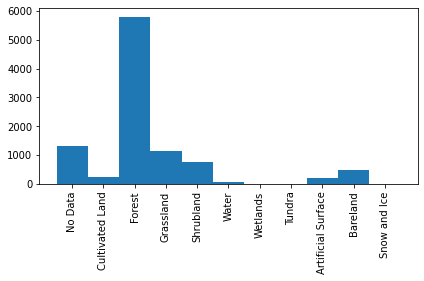

In [16]:
plt.hist(labels, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# **Experimental CNN**

In [19]:
train_labels_count = np.unique(labels, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,1308
1,1,238
2,2,5796
3,3,1125
4,4,770
5,5,58
6,8,217
7,9,488


In [43]:
train = {}
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train_data, labels, test_size=0.2, random_state=0)

In [44]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 8000
# of validation images: 2000


In [59]:
# Try Google's LeNet-5

model = keras.Sequential()

model.add(layers.Conv3D(filters=6, kernel_size=(1, 1, 1), activation='relu', input_shape=(12,33,33,6)))
model.add(layers.AveragePooling3D())

model.add(layers.Conv3D(filters=16, kernel_size=(1, 1, 1), activation='relu'))
model.add(layers.AveragePooling3D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=11, activation = 'softmax'))

In [60]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 10, 33, 33, 6)     114       
_________________________________________________________________
average_pooling3d_18 (Averag (None, 5, 16, 16, 6)      0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 3, 16, 16, 16)     304       
_________________________________________________________________
average_pooling3d_19 (Averag (None, 1, 8, 8, 16)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 120)               123000    
_________________________________________________________________
dense_28 (Dense)             (None, 84)              

In [61]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [62]:
history = model.fit(train_data, labels, batch_size=32, validation_split=0.2, validation_batch_size=8, epochs=5)

Epoch 1/5
211/250 [========================>.....] - ETA: 7s - loss: 0.0000e+00 - accuracy: 0.0269

KeyboardInterrupt: ignored